# fct_monthly_schedule_route_direction_summary
* schedule stats (headway, freq, n_trips) by route-direction
* operator summary charts
* [Tiffany's explanation](https://github.com/cal-itp/data-analyses/issues/1752#issuecomment-3563818122)

In [1]:
import datetime
import sys

import _sql_query
import google.auth
import pandas as pd
from google.cloud import bigquery
from loguru import logger
from shared_utils import rt_dates
from update_vars import SEGMENT_GCS

credentials, project = google.auth.default()

import _operator_grain_route_dir_visuals as _report_operator_visuals
from IPython.display import HTML, Image, Markdown, display, display_html
from omegaconf import OmegaConf
from shared_utils import gtfs_utils_v2, portfolio_utils, publish_utils
from update_vars import GTFS_DATA_DICT, RT_SCHED_GCS

readable_dict = OmegaConf.load("readable2.yml")

import altair as alt

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
# rt_dates.DATES

In [4]:
aug_2025 = "2025-08-20"

In [5]:
analysis_name = "City and County of San Francisco"

In [6]:
def formatted(number):
    return "{:,}".format(number)

In [7]:
df = _sql_query.download_with_pandas_gbq(
    project="cal-itp-data-infra-staging",
    filename="tiffany_mart_gtfs_rollup.fct_monthly_schedule_rt_route_direction_summary",
)


        SELECT 
            *
        FROM `cal-itp-data-infra-staging`.`tiffany_mart_gtfs_rollup`.`fct_monthly_schedule_rt_route_direction_summary`
        WHERE month_first_day >=  DATE('2025-01-01')
    


/opt/conda/lib/python3.11/site-packages/pandas_gbq/gbq.py:38: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa


Downloading: 100%|██████████|
download time: 0:00:08.018194


In [75]:
df.route_typology.unique()

array(['bus', 'express', 'rail', 'ferry', 'rapid', 'unknown'],
      dtype=object)

In [8]:
df2 = df[
    [
        "month_first_day",
        "name",
        "route_name",
        "direction_id",
        "frequency_all_day",
        "frequency_offpeak",
        "frequency_peak",
        "daily_service_hours",
        "daily_trips_peak",
        "daily_trips_offpeak",
        "daily_trips_all_day",
        "day_type",
    ]
]

In [9]:
df2 = df2.loc[df2.day_type == "Weekday"]

### Temporary step to add `analysis_name`

In [10]:
fct_monthly_schedule_df = df2.pipe(
    portfolio_utils.standardize_portfolio_organization_names
)

In [11]:
# fct_monthly_schedule_df.analysis_name.unique()

In [12]:
subset_df = fct_monthly_schedule_df.loc[
    fct_monthly_schedule_df.analysis_name.isin([analysis_name])
]

In [13]:
subset_df.shape

(349, 14)

In [14]:
subset_df.head(2)

,month_first_day,name,route_name,direction_id,frequency_all_day,frequency_offpeak,frequency_peak,daily_service_hours,daily_trips_peak,daily_trips_offpeak,daily_trips_all_day,day_type,analysis_name,source_record_id
747,2025-10-01,Bay Area 511 Muni Schedule,FBUS__FBUS MARKET & WHARVES BUS,0,0.25,NaN,NaN,0.53,NaN,NaN,1.00,Weekday,City and County of San Francisco,recHD22phgJs34JHP
748,2025-10-01,Bay Area 511 Muni Schedule,FBUS__FBUS MARKET & WHARVES BUS,0,0.25,NaN,NaN,0.53,NaN,NaN,1.00,Weekday,City and County of San Francisco,recHD22phgJs34JHP


### Lightly clean dataframe

In [15]:
subset_df.columns = subset_df.columns.str.replace("_", " ").str.title()

In [16]:
subset_df["Month First Day"] = pd.to_datetime(subset_df["Month First Day"]).dt.strftime(
    "%B %Y"
)

/tmp/ipykernel_3489/4125884978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["Month First Day"] = pd.to_datetime(subset_df["Month First Day"]).dt.strftime(


In [17]:
subset_df = subset_df.rename(
    columns={
        "Direction Id": "Direction",
        "Month First Day": "Date",
        "Route Name": "Route",
    }
)

### Operator Grain: Average Scheduled Minutes
* Use `daily_service_hours`
* Replace `avg_scheduled_min_chart` in `_report_operator_visuals`
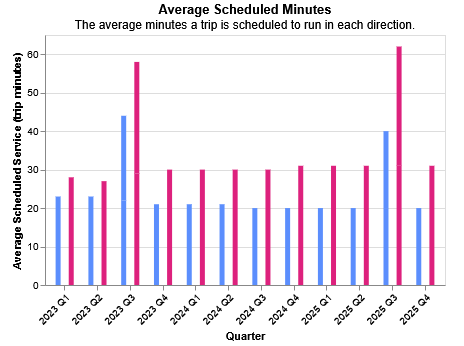

In [18]:
routes_list = subset_df["Route"].unique().tolist()

In [19]:
route_dropdown = alt.binding_select(
    options=routes_list,
    name="Routes: ",
)

# Column that controls the bar charts
xcol_param = alt.selection_point(
    fields=["Route"], value=routes_list[0], bind=route_dropdown
)

In [20]:
avg_scheduled_min_dict = readable_dict.avg_scheduled_min_graph

#### Need to divide this by `daily_trips_all_day` for this to make sense 

In [21]:
subset_df["Daily Service Minutes"] = subset_df["Daily Service Hours"] * 60

In [22]:
subset_df["Average Scheduled Minutes"] = (
    subset_df["Daily Service Minutes"] / subset_df["Daily Trips All Day"]
)

In [23]:
subset_df["Average Scheduled Minutes"].describe()

count   349.00
mean     40.04
std      15.31
min       9.30
25%      31.04
50%      41.83
75%      48.79
max      93.00
Name: Average Scheduled Minutes, dtype: float64

In [24]:
subset_df.sample().T

,9279
Date,October 2025
Name,Bay Area 511 Muni Schedule
Route,25__25 TREASURE ISLAND
Direction,1
Frequency All Day,2.73
Frequency Offpeak,2.61
Frequency Peak,2.97
Daily Service Hours,30.98
Daily Trips Peak,23.78
Daily Trips Offpeak,41.74


In [25]:
avg_scheduled_min_tooltip = ["Date", "Route", "Direction", "Daily Service Minutes"]

In [26]:
avg_scheduled_min_title = "Average Scheduled Minutes"

In [27]:
avg_scheduled_min_subtitle = (
    "The average minutes a trip is scheduled to run in each direction."
)

In [28]:
def bar_chart(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    color_col: str,
    color_scheme: list,
    tooltip_cols: list,
    date_format: str = "%b %Y",
) -> alt.Chart:

    chart = (
        alt.Chart(df)
        .mark_bar()
        .encode(
            x=alt.X(
                x_col,
                title=x_col,
                axis=alt.Axis(labelAngle=-45, format=date_format),
            ),
            y=alt.Y(y_col, title=y_col, axis=alt.Axis(labels=False)),
            color=alt.Color(
                color_col,
                legend=None,
                title=color_col,
                scale=alt.Scale(range=color_scheme),
            ),
            tooltip=tooltip_cols,
        )
    )

    return chart

In [29]:
options = [0, 1]

In [30]:
labels = ["0", "1"]

In [31]:
input_dropdown = alt.binding_radio(
    # Add the empty selection which shows all when clicked
    options=options,
    labels=labels,
    name="Direction: ",
)

In [32]:
selection = alt.selection_point(
    fields=["Direction"],
    bind=input_dropdown,
)

In [33]:
(
    bar_chart(
        df=subset_df,
        x_col="Date",
        y_col="Daily Service Minutes",
        color_col="Direction:N",
        color_scheme=[*avg_scheduled_min_dict.colors],
        tooltip_cols=avg_scheduled_min_tooltip,
        date_format="",
    )
    .add_params(xcol_param)
    .transform_filter(xcol_param)
).add_params(selection).transform_filter(selection)

alt.Chart(...)

In [34]:
_report_operator_visuals.configure_chart(
    avg_scheduled_min_chart,
    width=400,
    height=250,
    title=avg_scheduled_min_title,
    subtitle=avg_scheduled_min_subtitle,
)

NameError: name 'avg_scheduled_min_chart' is not defined

### Operator: Total Scheduled Trips for Vehicles Going Direction X
* Use `daily_trips_all_day`

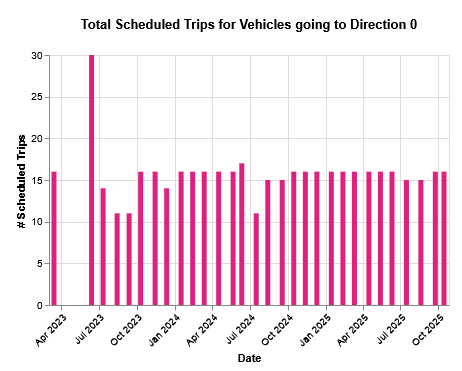

In [35]:
n_scheduled_dict = readable_dict.n_scheduled_graph

In [36]:
n_scheduled_tooltip = [
    "Date",
    "Route",
    "Direction",
    "Daily Trips All Day",
]

In [37]:
n_scheduled_title = "Total Scheduled Trips"

In [38]:
total_scheduled_trips_graph = (
    _report_operator_visuals.grouped_bar_chart(
        subset_df,
        x_col="Date",
        y_col="Daily Trips All Day",
        color_col="Direction:N",
        color_scheme=[*n_scheduled_dict.colors],
        tooltip_cols=n_scheduled_tooltip,
        date_format="",
        offset_col="Direction:N",
    )
    .add_params(xcol_param)
    .transform_filter(xcol_param)
)

In [39]:
_report_operator_visuals.configure_chart(
    total_scheduled_trips_graph,
    width=400,
    height=250,
    title=n_scheduled_title,
    subtitle=n_scheduled_dict.subtitle,
)

alt.Chart(...)

### Frequency of Trips Peak/Off Peak for Direction X
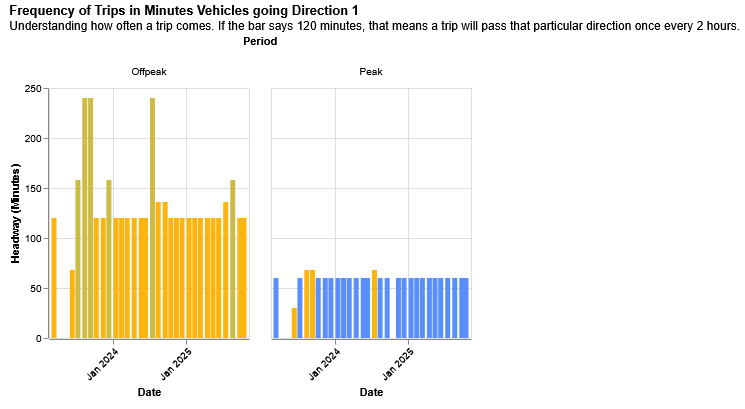

In [40]:
frequency_dict = readable_dict.frequency_graph

In [41]:
frequency_tooltip = [
    "Date",
    "Route",
    "Direction",
    "Period",
    "Headway (Minutes)",
]

In [42]:
frequency_title = "Headway"

#### Need to manipulate this data a bit to be in the right format.

In [43]:
frequency_subset = subset_df[
    ["Route", "Direction", "Frequency Offpeak", "Frequency Peak", "Date"]
].melt(
    id_vars=["Date", "Route", "Direction"],
    value_vars=["Frequency Offpeak", "Frequency Peak"],
)

In [44]:
frequency_subset.value = 60 / frequency_subset.value

In [45]:
frequency_subset = frequency_subset.rename(
    columns={"variable": "Period", "value": "Headway (Minutes)"}
)

In [46]:
frequency_subset.loc[
    (frequency_subset.Route == "30__30 STOCKTON")
    & (frequency_subset.Date == "April 2025")
]

,Date,Route,Direction,Period,Headway (Minutes)


In [47]:
frequency_graph = _report_operator_visuals.bar_chart(
    x_col="Date",
    y_col="Headway (Minutes)",
    color_col="Headway (Minutes):N",
    color_scheme=frequency_dict.colors,
    tooltip_cols=frequency_tooltip,
    date_format="",
)

In [48]:
direction_str = str(0)

In [49]:
frequency_graph = (
    alt.layer(
        frequency_graph, data=frequency_subset.loc[frequency_subset.Direction == 0]
    )
    .encode(y=alt.Y("Headway (Minutes)", scale=alt.Scale(domain=[0, 250], clamp=True)))
    .properties(width=200, height=250)
)

In [50]:
frequency_graph = frequency_graph.facet(
    column=alt.Column(
        "Period:N",
    )
).properties(
    title={
        "text": f"{frequency_dict.title} Vehicles going Direction {direction_str}",
        "subtitle": frequency_dict.subtitle,
    }
)

#### Adding the route dropdown doesn't work when I'm using the melted dataframe.

In [73]:
frequency_graph

alt.FacetChart(...)

#### Try to create a version of this with the original dataframe.

In [52]:
subset_df.head(1)

,Date,Name,Route,Direction,Frequency All Day,Frequency Offpeak,Frequency Peak,Daily Service Hours,Daily Trips Peak,Daily Trips Offpeak,Daily Trips All Day,Day Type,Analysis Name,Source Record Id,Daily Service Minutes,Average Scheduled Minutes
747,October 2025,Bay Area 511 Muni Schedule,FBUS__FBUS MARKET & WHARVES BUS,0,0.25,NaN,NaN,0.53,NaN,NaN,1.00,Weekday,City and County of San Francisco,recHD22phgJs34JHP,32.00,32.00


In [53]:
subset_df["Headway Offpeak"] = 60 / subset_df["Frequency Offpeak"]

In [54]:
subset_df["Headway Peak"] = 60 / subset_df["Frequency Peak"]

In [55]:
subset_df["Headway All Day"] = 60 / subset_df["Frequency All Day"]

In [56]:
subset_df["Headway Offpeak"].describe()

count   122.00
mean     16.28
std       4.61
min       9.45
25%      13.79
50%      15.21
75%      20.26
max      26.09
Name: Headway Offpeak, dtype: float64

In [57]:
subset_df["Headway Peak"].describe()

count   296.00
mean     14.67
std       6.20
min       5.32
25%      10.08
50%      12.88
75%      20.00
max      30.15
Name: Headway Peak, dtype: float64

In [58]:
subset_df.loc[subset_df["Headway Peak"] >= 20].sample(3)

,Date,Name,Route,Direction,Frequency All Day,Frequency Offpeak,Frequency Peak,Daily Service Hours,Daily Trips Peak,Daily Trips Offpeak,Daily Trips All Day,Day Type,Analysis Name,Source Record Id,Daily Service Minutes,Average Scheduled Minutes,Headway Offpeak,Headway Peak,Headway All Day
9282,October 2025,Bay Area 511 Muni Schedule,25__25 TREASURE ISLAND,0,2.73,2.61,2.97,10.16,23.78,41.74,65.52,Weekday,City and County of San Francisco,recHD22phgJs34JHP,609.30,9.30,22.99,20.20,21.98
8837,October 2025,Bay Area 511 Muni Schedule,54__54 FELTON,0,2.35,NaN,2.88,41.58,23.00,24.00,47.00,Weekday,City and County of San Francisco,recHD22phgJs34JHP,2494.70,53.08,NaN,20.83,25.53
8701,October 2025,Bay Area 511 Muni Schedule,37__37 CORBETT,0,2.22,NaN,2.93,22.26,23.48,20.83,44.30,Weekday,City and County of San Francisco,recHD22phgJs34JHP,1335.57,30.15,NaN,20.48,27.03


In [59]:
subset_df.columns

Index(['Date', 'Name', 'Route', 'Direction', 'Frequency All Day',
       'Frequency Offpeak', 'Frequency Peak', 'Daily Service Hours',
       'Daily Trips Peak', 'Daily Trips Offpeak', 'Daily Trips All Day',
       'Day Type', 'Analysis Name', 'Source Record Id',
       'Daily Service Minutes', 'Average Scheduled Minutes', 'Headway Offpeak',
       'Headway Peak', 'Headway All Day'],
      dtype='object')

In [60]:
frequency_graph2 = _report_operator_visuals.bar_chart(
    x_col="Date",
    y_col="Headway Peak",
    color_col="Headway Peak",
    color_scheme=frequency_dict.colors,
    tooltip_cols=["Route", "Direction", "Headway Peak"],
    date_format="",
)

In [61]:
frequency_graph2 = alt.layer(frequency_graph2, data=subset_df)

#### Faceting chart causes the route dropdown to not work, no matter which dataframe I use.

In [62]:
frequency_graph2.encode(
    y=alt.Y("Headway Peak", scale=alt.Scale(domain=[0, 250], clamp=True))
).facet(
    column=alt.Column(
        "Direction:N",
    )
)

alt.FacetChart(...)

In [63]:
frequency_graph2.encode(
    y=alt.Y("Headway Peak", scale=alt.Scale(domain=[0, 250], clamp=True))
).facet(
    column=alt.Column(
        "Direction:N",
    )
).add_params(
    xcol_param
).transform_filter(
    xcol_param
)

alt.FacetChart(...)

In [64]:
frequency_graph2.encode(
    y=alt.Y("Headway Peak", scale=alt.Scale(domain=[0, 250], clamp=True))
).properties(
    title={
        "text": "Headway during Peak Hours",
    }
).add_params(
    xcol_param
).transform_filter(
    xcol_param
)

alt.LayerChart(...)

#### Need to make 4 charts in total then add them together OR should I just make 2 charts?

4 charts
* Dir 1 - Peak
* Dir 1 - Offpeak
* Dir 0 -Peak
* Dir 0 -Offpeak

2 charts
* Dir 1- All Day
* Dir 2 - All Day

In [65]:
subset_df.sample()

,Date,Name,Route,Direction,Frequency All Day,Frequency Offpeak,Frequency Peak,Daily Service Hours,Daily Trips Peak,Daily Trips Offpeak,Daily Trips All Day,Day Type,Analysis Name,Source Record Id,Daily Service Minutes,Average Scheduled Minutes,Headway Offpeak,Headway Peak,Headway All Day
9928,October 2025,Bay Area 511 Muni Schedule,19__19 POLK,0,3.32,NaN,3.96,59.47,31.65,34.65,66.30,Weekday,City and County of San Francisco,recHD22phgJs34JHP,3568.26,53.82,NaN,15.15,18.07


In [66]:
subset_df.loc[
    (subset_df.Route.str.contains("FBUS")) & (subset_df.Date == "September 2025")
]

,Date,Name,Route,Direction,Frequency All Day,Frequency Offpeak,Frequency Peak,Daily Service Hours,Daily Trips Peak,Daily Trips Offpeak,Daily Trips All Day,Day Type,Analysis Name,Source Record Id,Daily Service Minutes,Average Scheduled Minutes,Headway Offpeak,Headway Peak,Headway All Day


In [67]:
df_dir1 = subset_df.loc[(subset_df.Direction == 1)]

In [68]:
frequency_graph3 = _report_operator_visuals.bar_chart(
    x_col="Date",
    y_col="Headway All Day",
    color_col="Headway All Day",
    color_scheme=frequency_dict.colors,
    tooltip_cols=["Route", "Direction", "Headway All Day"],
    date_format="",
)

In [69]:
frequency_graph3 = alt.layer(frequency_graph3, data=df_dir1)

In [70]:
frequency_graph3 = frequency_graph3.encode(
    y=alt.Y("Headway Peak", scale=alt.Scale(domain=[0, 250], clamp=True))
)

In [71]:
_report_operator_visuals.configure_chart(
    frequency_graph3,
    width=400,
    height=250,
    title=f"{frequency_dict.title} for Direction 1",
    subtitle=frequency_dict.subtitle,
).add_params(xcol_param).transform_filter(xcol_param)

alt.LayerChart(...)